# Results

In this section, we present the trajectory reconstruction performances of the drift models presented in **?@sec-model-drif-traj**, and the dispersion characteristics of the drifters ensembles in the different regions of deployment.

## Modeling of drifter trajectories

Two models were used to reconstruct the drifter trajectories: a linear combination model (**?@sec-linear-combination**) and the Maxey-Riley framework (**?@sec-mr-framework**).

### Linear combination

Before employing the linear combination model, we first estimated the parameters controlling the Ekman current magnitude (i.e. $A_z$) and the windage coefficients (i.e. $\beta_{w_S}$ and $\beta_{w_M}$) from the SPOT and MELODI drifter observations, as described in **?@sec-lin-comb-param-estimation**.

In [ ]:
import os
import sys

import pandas as pd

sys.path.append(os.path.abspath("../src"))
from least_square import least_square_fit


base_dir = "../data/drifters"
l1_dir = f"{base_dir}/l1"

spot_l1_df = pd.read_parquet(os.path.join(l1_dir, "spot_l1_df.parquet"))
melodi_l1_df = pd.read_parquet(os.path.join(l1_dir, "melodi_l1_df.parquet"))

drifter_l1_df, params = least_square_fit(spot_l1_df, melodi_l1_df)

Az = 1 / (params[0] ** 2)
beta_ws = params[1]
beta_wm = params[2]

As can be seen in <a href="#tbl-lin-mod-param-val" class="quarto-xref">Table 1</a>, the vertical eddy viscosity $A_z$ estimated from the drifter data is $0.027 \text{ m}^2\text{s}^{-1}$, which is within the expected range for open ocean conditions. Howerver, the windage coefficients are lower than expected, with values of $0.092 \text{ \%}$ and $0.65 \text{ \%}$ for the SPOT and MELODI drifters respectively, while expected values are usually between $1 \text{ \%}$ to $3 \text{ \%}$.

In [19]:
from IPython.display import Markdown
from tabulate import tabulate


Markdown(tabulate(
    [[Az, beta_ws * 100, beta_wm * 100]],
    headers=["$A_z (\\text{m}^2 \\text{s}^{-1})$", "$\\beta_{w_S} (\%)$", "$\\beta_{w_M} (\%)$"],
    floatfmt=(".3f", ".3f", ".2f")
))

Using the estimated parameters, we then reconstructed 7-days drifter trajectories as solutions to the ODE given by **?@eq-lin-comb-ode**. To keep this report short, we decided to focus on the MELODI drifters as they provide higher-frequency GPS data compared to the SPOT drifters. We selected three MELODI drifters released in different locations and under varying oceanic and atmospheric conditions:

-   #301434060093370 deployed in the Lofoten Vortex on April 25, 2025, characterized by strong balanced currents and winds,
-   #301434060982270 deployed off the coast of Portugal on May 24, 2025, under weak balanced currents and moderate winds,
-   #301434060983290 deployed in the Balearic Sea on June 1, 2025, in a strong cyclonic stucture and almost no wind except for a brief blow from the East.

In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import jax

jax.config.update("jax_enable_x64", True)

sys.path.append(os.path.abspath("../src"))
from forcings import get_forcings
from linear_model import LinearCombination
from linear_reconstruction import linear_reconstruction


base_dir = "../data/drifters"
l2_dir = f"{base_dir}/l2"

melodi_l2_df = pd.read_parquet(os.path.join(l2_dir, "melodi_l2_df.parquet"))

# Avoid re-fitting the model; hard-code previously estimated parameters
Az = 0.027164294179297017
beta_wm = 0.006456534645157547
model = LinearCombination(Az=Az, beta_w=beta_wm)
horizon_days = 7

lof_true_traj, lof_est_traj = linear_reconstruction(
    model, melodi_l2_df, 0, np.datetime64("2025-04-25T20:00:00"), horizon_days
)
na_true_traj, na_est_traj = linear_reconstruction(
    model, melodi_l2_df, 30, np.datetime64("2025-05-24T12:00:00"), horizon_days
)
med_true_traj, med_est_traj = linear_reconstruction(
    model, melodi_l2_df, 35, np.datetime64("2025-06-01T22:00:00"), horizon_days
)

vardyn_ds, wind_ds, wave_ds = get_forcings()

In [13]:
import cartopy.crs as ccrs
import cmocean.cm as cmo
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt


def plot_trajectories(true_traj, est_traj, ax):
    def aligned_range(min_val, max_val, spacing):
        start = np.ceil(min_val / spacing) * spacing
        end   = np.floor(max_val / spacing) * spacing
        return np.arange(start, end + spacing / 2, spacing)
    
    points_idx = ((np.arange(horizon_days) + 1) * 24).astype(int)

    ax.plot(
        true_traj.value[0,1], true_traj.value[0,0], 
        marker="o", markersize=4, c="mediumvioletred", linewidth=1
    )
    ax.plot(
        est_traj.value[0,1], est_traj.value[0,0], '--', 
        marker="x", markersize=4, c="mediumvioletred", linewidth=1
    )
    ax.plot(true_traj.value[:,1], true_traj.value[:,0], c="mediumvioletred", linewidth=1)
    ax.plot(est_traj.value[:,1], est_traj.value[:,0], '--', c="mediumvioletred", linewidth=1)

    min_lon, max_lon = np.asarray(ax.get_xlim()) + np.asarray([-0.1, 0.1])
    min_lat, max_lat = np.asarray(ax.get_ylim()) + np.asarray([-0.1, 0.1])

    mid_time = np.datetime64(int(true_traj.times.value[len(true_traj.times.value) // 2].item()), "s")
    _vardyn_ds = vardyn_ds.sel(time=mid_time, method="nearest").sel(
        latitude=slice(min_lat, max_lat), longitude=slice(min_lon, max_lon)
    )
    _wind_ds = wind_ds.sel(time=mid_time, method="nearest").sel(
        latitude=slice(min_lat, max_lat), longitude=slice(min_lon, max_lon)
    )

    im = ax.pcolormesh(
        _vardyn_ds.longitude, _vardyn_ds.latitude, np.sqrt(_vardyn_ds.ucos**2 + _vardyn_ds.vcos**2),
        cmap=cmo.ice, vmin=0, vmax=.5, shading="auto", linewidth=0
    )
    ax.quiver(
        _wind_ds.longitude, _wind_ds.latitude, _wind_ds.eastward_wind, _wind_ds.northward_wind, scale=400, color="gray"
    )
    num = 3
    ax.quiver(
        _vardyn_ds.longitude[::num], _vardyn_ds.latitude[::num], 
        _vardyn_ds.ucos[::num, ::num], _vardyn_ds.vcos[::num, ::num], 
        scale=10, color="aliceblue"
    )

    ax.scatter(true_traj.value[points_idx,1], true_traj.value[points_idx,0], marker="o", s=16, c="mediumvioletred")
    ax.scatter(est_traj.value[points_idx,1], est_traj.value[points_idx,0], marker="x", s=16, c="mediumvioletred")

    lon_ticks = aligned_range(min_lon, max_lon, spacing=0.5)
    lat_ticks = aligned_range(min_lat, max_lat, spacing=0.25)
    gl = ax.gridlines(
        draw_labels=True, xlocs=lon_ticks, ylocs=lat_ticks, linewidth=0.5, color="gray", alpha=0.5, linestyle="--"
    )

    return im, gl


fig, axd = plt.subplot_mosaic(
    """
    BA
    BC
    """,
    width_ratios=[.4, .6],
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    #gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(12, 5), layout="compressed"
)

_, gl_b = plot_trajectories(na_true_traj, na_est_traj, axd["B"])
_, gl_a = plot_trajectories(lof_true_traj, lof_est_traj, axd["A"])
im, gl_c = plot_trajectories(med_true_traj, med_est_traj, axd["C"])

gl_b.top_labels = False
gl_b.right_labels = False
gl_a.bottom_labels = False
gl_a.left_labels = False
gl_c.top_labels = False
gl_c.left_labels = False

clb = fig.colorbar(
    im, ax=axd.values(), location="bottom", shrink=.66, extend="max"
)
clb.set_label(label="$\| u_{cg} \|$ (m s$^{-1}$)")

line_handles = [
    Line2D([], [], color="mediumvioletred", marker="o", lw=1, label="Reference"),
    Line2D([], [], color="mediumvioletred", marker="x", linestyle="--", lw=1, label="Simulated"),
]
leg1 = fig.legend(
    handles=line_handles, loc="upper center", ncol=2, frameon=True, bbox_to_anchor=(0.5, 0.975)
)
fig.add_artist(leg1)

plt.show()

The reconstructed trajectories (dashed lines) are shown in <a href="#fig-lin-comb-est" class="quarto-xref">Figure 1</a> against the true drifter trajectories (solid lines) over a 7-day horizon. Markers indicate daily positions along the trajectories. Background colors indicate the magnitude of the cyclogeostrophic current from the VarDyn and white arrows give their velocity, while grey arrows represent wind velocity from the ERA5 reanalysis. The geophysical fields are represented at for the center timestamp of each trajectory. Metrics quantifying the reconstruction performance, namely the final separation distance and the Liu index, are reported in <a href="#tbl-lin-mod-eval" class="quarto-xref">Table 2</a>.

It can be seen that the reconstructed trajectory in the Lofoten Vortex (top right panel of <a href="#fig-lin-comb-est" class="quarto-xref">Figure 1</a>) closely follows the true drifter trajectory but at a much slower pace. It suggests that the cyclogeostrophic currents are well captured by the VarDyn product, but that the Ekman current (usually the second largest term in a linear combination drift model) might be underestimated. Because of the strong winds and currents, another possible explaination for this discrepancy could be an inacurrate representation of the wind-current interactions. This results in a final separation distance of approximately 29 km after 7 days, and a Liu Index of 0.23, indicating that the estimation separates four times more slowly than the drifter moves.

The trajectory reconstructed off the Portuguese coast (left panel of <a href="#fig-lin-comb-est" class="quarto-xref">Figure 1</a>) shows a larger deviation from the true drifter trajectory, with a final separation distance of approximately 76 km and a Liu index of 0.32. By looking at <a href="#fig-lin-comb-est" class="quarto-xref">Figure 1</a>, it appears that the drifter followed a small-scale structure heading South-South-East and not captured by satellite-derived observations products, while the reconstruction follows a current oriented slightly more to the West.

Finally, the trajectory reconstructed in the Balearic Sea (bottom right panel of <a href="#fig-lin-comb-est" class="quarto-xref">Figure 1</a>) shows an averall very good agreement with the true drifter trajectory, with a final separation distance of approximately 35 km but more importantly a Liu index of 0.1, meaning that the distance between the estimation and the reference grows ten times slowly than the drifter displaces. The westward gust of wind is clearly visible in the reference trajectory because of the inertial oscillations it generates, a process that is not represented at all in the linear combination drift model.

In [14]:
from IPython.display import Markdown
from tabulate import tabulate


Markdown(tabulate(
    [
        [
            "Lofoten Vortex", 
            lof_true_traj.separation_distance(lof_est_traj).value[-1] / 1e3, 
            lof_true_traj.liu_index(lof_est_traj).value[-1]
        ], 
        [
            "Portuguese Coast", 
            na_true_traj.separation_distance(na_est_traj).value[-1] / 1e3, 
            na_true_traj.liu_index(na_est_traj).value[-1]
        ], 
        [
            "Balearic Sea", 
            med_true_traj.separation_distance(med_est_traj).value[-1] / 1e3, 
            med_true_traj.liu_index(med_est_traj).value[-1]
        ]
    ],
    headers=["Region", "Separation distance (km)", "Liu Index"],
    floatfmt=("g", ".0f", ".2f")
))

### Maxey-Riley framework

We will use the data from MELODI drifters since they provide a better time resolution that the SPOT drifters (they transmit in regular intervals). As shown in **?@fig-melodi-design**, they are not spherical. To take their shape into account, we calculate the radius of the sphere with equivalent projected area, surface area and equivalent volume (**?@eq-K-melodi**), obtaining $a_n$ = 0.08 m, $a_s$ = 0.12 m and $a_v$ = 0.11 m. The weight on the bottom of the drifters is not taken into account for this calculations but the total weight of the drifter is considered to calculate its density. We use a combination of all the currents present at the surface to compute $v_f$ (Ekman, Stokes and the cyclogesotrophic currents) and the wind at the surface to compute $v_a$.

We consider three representative cases: a deployment in the Norwegian Sea, one in the Atlantic Ocean and one in the Mediterranean Sea. <a href="#fig-MR-lofoten" class="quarto-xref">Figure 2</a> shows the drifter real trajectory for a week after release in the Lofoten Vortex on the 24th April and the reconstructed trajectory from the Maxey-Riley framework, obtained using **?@eq-MR**. We can observe that the reconstructed trajectory follows the general tendency of the real one but it does not exactly follow the same path, and seems to move with a slower speed than the real drifter. It is worth noting that the drifter seems to be highly influenced by the wind (blowing northward).

<a href="#fig-MR-atlantic" class="quarto-xref">Figure 3</a> shows the real and simulated trajectories for a deployment made in the Atlantic Ocean on the 23rd May. Remarkably, in this case the simulated trajectory is really close to the real one. Nevertheless, it does not seem to take into account the small scale oscillations visible in the real trajectory. These oscillations are usually generated by waves and are not visible in the sattelite data, which could explain why the simulation did not account for them.

It is important to remind that these numerical resolutions do not have any fitting parameter. They only depend on the currents and wind fields (products derived from sattelite data), the initial position of the drifter and its geometry. The numerical resolution is thus very sensitive to changes in those parameters. For example, several runs of the simulation with slight changes of the initial position give rise to a different outcome, which may not be close to the real one. <a href="#fig-MR-mediterranean" class="quarto-xref">Figure 4</a> shows the real and simulated trajectories for a deployment made in the Mediterranean Sea on the 30th May. In this case, the deployment was made at the interface between two vortices and the wind was blowing westward. The simulated trajectory does not follow the real one. We will discuss the possible reasons in the **?@sec-disc**.

<figure id="fig-MR-lofoten">
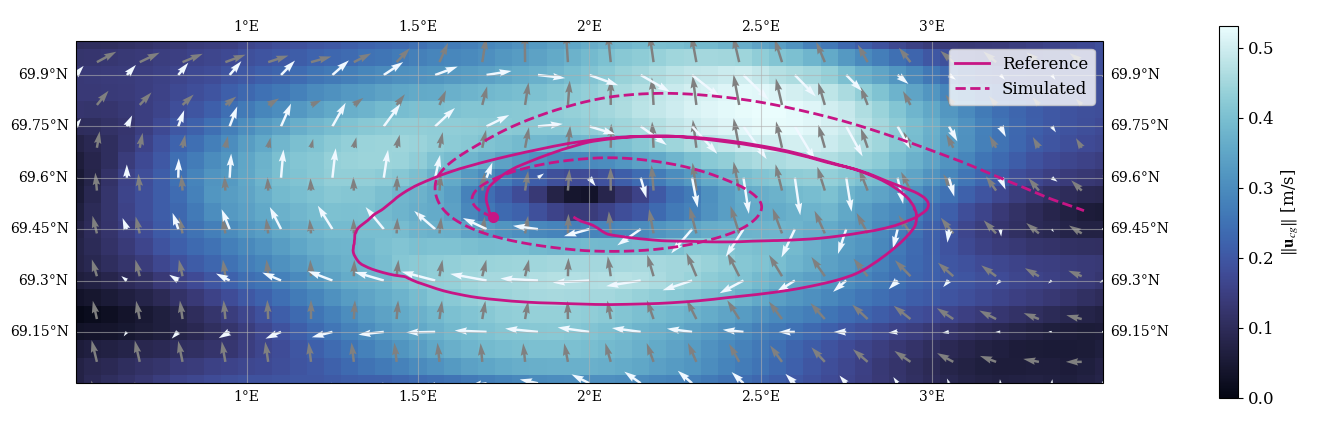
<figcaption>Figure 2: Drifter trajectory on the Lofoten Vortex during one week after deployment. The solid lines indicate the real trajectory, while the dashed lines show the result of solving the Maxey-Riley set. The colors indicate the absolute value of the cyclogeostrophic current at the moment of release. The white arrows show the direction of the current and the gray arrows indicate the wind direction.</figcaption>
</figure>

<figure id="fig-MR-atlantic">
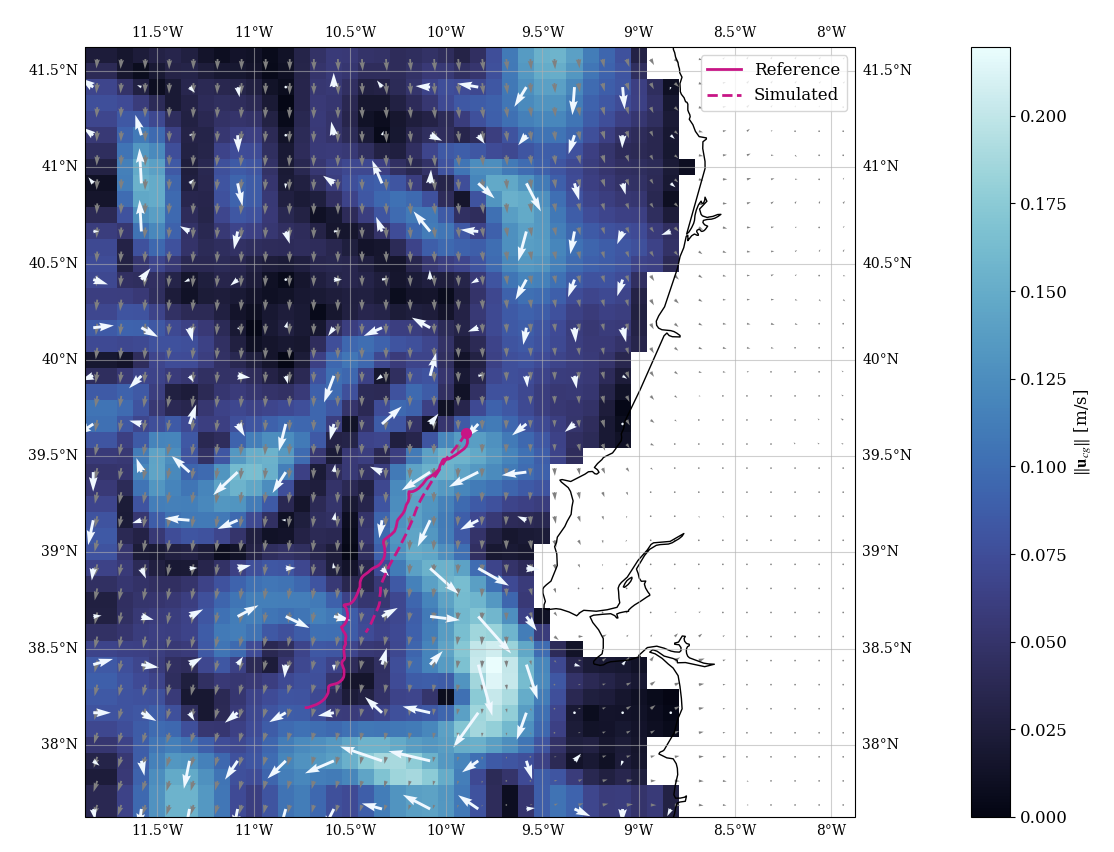
<figcaption>Figure 3: Drifter trajectory in the Atlantic Ocean, near the Portuguese coast, during one week after deployment. The solid lines indicate the real trajectory, while the dashed lines show the result of solving the Maxey-Riley set. The colors indicate the absolute value of the cyclogeostrophic current at the moment of release. The white arrows show the direction of the current and the gray arrows indicate the wind direction.</figcaption>
</figure>

<figure id="fig-MR-mediterranean">
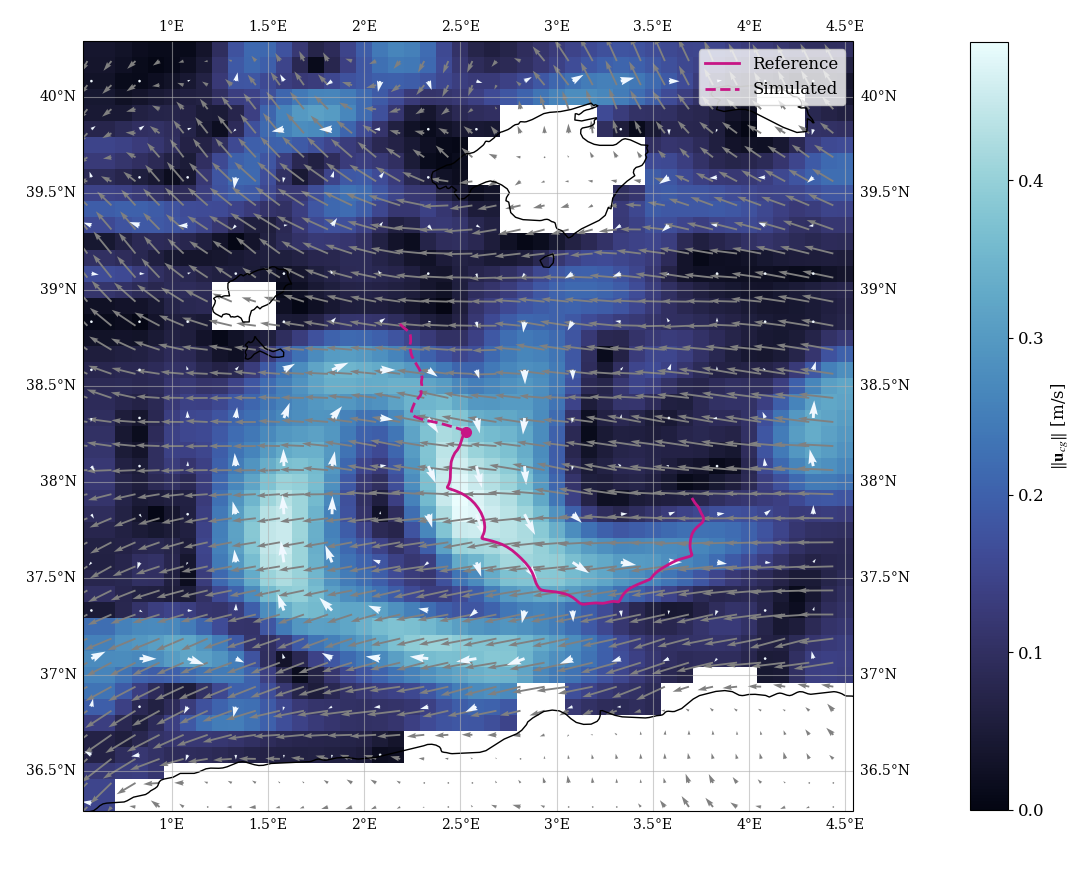
<figcaption>Figure 4: Drifter trajectory on the Mediterranean Sea during one week after deployment. The solid lines indicate the real trajectory, while the dashed lines show the result of solving the Maxey-Riley set. The colors indicate the absolute value of the cyclogeostrophic current at the moment of release. The white arrows show the direction of the current and the gray arrows indicate the wind direction.</figcaption>
</figure>

## Pair dispersion

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
scripts_path = os.path.join(os.path.dirname(os.getcwd()), 'scripts')
sys.path.append(scripts_path)
from functions_pair_dispersion import get_trajectory, create_trajectories_and_times_list, create_mask_trajectories_optimized, temporal_interpolation, distance_pair, K_pair, apply_mask_KD, calculate_pair_separation_pair_diffusivity_and_mask_pair
import pandas as pd

from datetime import date
import os
from matplotlib.lines import Line2D
import cmocean.cm as cmo

import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, Real
import xarray as xr


from pastax.trajectory import Trajectory

In [ ]:
# Figure styling
from matplotlib import rc
import matplotlib as mpl

rc('lines',  markersize=10)
rc("legend", fontsize=20)
rc("axes", labelsize=20)
rc("xtick", labelsize=20)
rc("ytick", labelsize=20)
rc("lines", linewidth=1.5)

mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']+ mpl.rcParams['font.serif']
mpl.rcParams["mathtext.fontset"] = "stix"
#mpl.rcParams['text.usetex'] = True

cmap = plt.colormaps["ocean"]
cmap = cmo.speed

In [ ]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

In [ ]:
base_dir = "../data/drifters"
l2_dir = f"{base_dir}/l2"


spot_l2_df = pd.read_parquet(os.path.join(l2_dir, "spot_l2_df.parquet"))

spot_l2_df['deploy_date'] = pd.to_datetime(spot_l2_df['deploy_time']).dt.date

date_deployment_1 = date(2025, 5, 12)
date_deployment_2 = date(2025, 5, 18)
date_deployment_3 = date(2025, 5, 24)
date_deployment_4 = date(2025, 5, 30)

drifters_deployment_1 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_1]['drifter_id'].unique()
drifters_deployment_2 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_2]['drifter_id'].unique()
drifters_deployment_3 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_3]['drifter_id'].unique()
drifters_deployment_4 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_4]['drifter_id'].unique()


def create_trajectories_and_times_list(drifters_id, spot_l2_df):
    traj_list = []
    for i in range(len(drifters_id)):
        drifter_id = drifters_id[i]
        df = spot_l2_df[spot_l2_df["drifter_id"] == drifter_id]

        traj = Trajectory.from_array(
            jnp.stack((jnp.asarray(df['lat']), jnp.asarray(df['lon'])), axis=-1), 
            jnp.asarray(np.asarray(df['time']).astype("datetime64[s]").astype(int)))
        traj_list.append(traj)

    traj_times = []
    for traj in traj_list:
        traj_times.append(np.asarray(traj.times.value).astype("datetime64[s]"))
    return traj_list, traj_times

traj_list_1, traj_times_1 = create_trajectories_and_times_list(drifters_deployment_1, spot_l2_df)
traj_list_2, traj_times_2 = create_trajectories_and_times_list(drifters_deployment_2, spot_l2_df)
traj_list_3, traj_times_3 = create_trajectories_and_times_list(drifters_deployment_3, spot_l2_df)
traj_list_4, traj_times_4 = create_trajectories_and_times_list(drifters_deployment_4, spot_l2_df)



dt = 30*60 # in seconds
ts_1 = np.arange(date_deployment_1, np.datetime64('now'), np.timedelta64(30,'m'))
ts_2 = np.arange(date_deployment_2, np.datetime64('now'), np.timedelta64(30,'m'))
ts_3 = np.arange(date_deployment_3, np.datetime64('now'), np.timedelta64(30,'m'))
ts_4 = np.arange(date_deployment_4, np.datetime64('now'), np.timedelta64(30,'m'))

masks_time_1 = create_mask_trajectories_optimized(traj_list_1, traj_times_1, ts_1)
masks_time_2 = create_mask_trajectories_optimized(traj_list_2, traj_times_2, ts_2)
masks_time_3 = create_mask_trajectories_optimized(traj_list_3, traj_times_3, ts_3)
masks_time_4 = create_mask_trajectories_optimized(traj_list_4, traj_times_4, ts_4)

interpolated_trajs_1 = temporal_interpolation(traj_list_1, masks_time_1, ts_1, traj_times_1)
interpolated_trajs_2 = temporal_interpolation(traj_list_2, masks_time_2, ts_2, traj_times_2)
interpolated_trajs_3 = temporal_interpolation(traj_list_3, masks_time_3, ts_3, traj_times_3)
interpolated_trajs_4 = temporal_interpolation(traj_list_4, masks_time_4, ts_4, traj_times_4)

Ds_1, Ks_1, mask_pair_1 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_1, masks_time_1, dt)
Ds_2, Ks_2, mask_pair_2 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_2, masks_time_2, dt)
Ds_3, Ks_3, mask_pair_3 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_3, masks_time_3, dt)
Ds_4, Ks_4, mask_pair_4 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_4, masks_time_4, dt)


We used the home-made SPOT drifters to study pair dispersion. They are designed to transmit their position every 30 minutes. However, this is not always the case. In order to calculate the distance betwen a pair of drifters, they should have transmitted in the same time interval. <a href="#fig-pair-masks" class="quarto-xref">Figure 5</a> shows in black when each drifter transmitted its position, using a time interval of 30 minutes. This trajectories have already been interpolated in time (L2 version). For each deployment of $N=5$ drifters, there are $N(N-1)/2 = 10$ pairs. For each pair, we will consider their positions if they transmitted at the same time interval.

Considering the variability of the conditions for making *in-situ* measurements, each group of drifters behave differently. We can observe that there are several pairs for the first and third depoyments, but less simultaneous transmissions for the second and fourth. For example, on the last deployment one drifter stop transmitting almost inmediately, so we have only 6 pairs. But if we take a closer look at <a href="#fig-pair-masks" class="quarto-xref">Figure 5</a> (d) we see that in practice we have only one pair of drifters that transmitted for more than a month.

In [ ]:
fig, ax = plt.subplots(2,2, sharex = True, sharey = True, figsize = (18,10))

ax[0,0].imshow(masks_time_1, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_1.shape[1]*30/1440, 0.50, masks_time_1.shape[0] + 0.5))
ax[0,1].imshow(masks_time_2, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_2.shape[1]*30/1440, 0.50, masks_time_2.shape[0] + 0.5))
ax[1,0].imshow(masks_time_3, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_3.shape[1]*30/1440, 0.50, masks_time_3.shape[0] + 0.5))
ax[1,1].imshow(masks_time_4, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_4.shape[1]*30/1440, 0.50, masks_time_4.shape[0] + 0.5))

ax[0,0].set_title('(a) Deployment 1', fontsize = 20)
ax[0,1].set_title('(b) Deployment 2', fontsize = 20)
ax[1,0].set_title('(c) Deployment 3', fontsize = 20)
ax[1,1].set_title('(d) Deployment 4', fontsize = 20)

ax[0,0].set_ylabel('N° of drifter')
ax[1,0].set_ylabel('N° of drifter')

ax[0,0].set_ylim(0.5, masks_time_1.shape[0] + 0.5)

ax[1,0].set_xlabel('time since release [days]')
ax[1,1].set_xlabel('time since release [days]')

plt.tight_layout()
plt.show()

<a href="#fig-pair-dispersion" class="quarto-xref">Figure 6</a> shows the pair dispersion $D^2$ as a function of time for each deployment. As discussed before, for the first and third deployments we have several pairs while we do not have enough data for the second and fourth. In <a href="#fig-pair-dispersion" class="quarto-xref">Figure 6</a> (a) we can clearly observe two different behaviors: an exponential growth for the first two weeks after release, and a different regime after. Pink lines indicate the exponential and the Richardson regimes, showing a good agreement with the measured data. The third deployment, however, seems to show only an exponential behavior. It follows a scaling law $D^2 \propto e^{ \alpha t}$, with a growth rate of $\alpha = 5$. Unexpectedly, this growth rate is bigger than the one of the first deployment but the particles remain in an exponential regime. This can be due to a difference in transition thresholds. If the transition scale (the size of the biggest eddies in the flow) varies, we expect the first group of drifters ro reach the Richardson regime sooner despite slower growth, while the third group of drifters remain in exponential regime but still relatively close together, not yet having reached their larger transition threshold.

In [ ]:
index_plot_D = ['(a)', '(b)', '(c)', '(d)']
index_plot_K = ['(a)', '(b)', '(c)', '(d)']

datasets = [
    (Ds_1, Ks_1, mask_pair_1, ts_1, interpolated_trajs_1),
    (Ds_2, Ks_2, mask_pair_2, ts_2, interpolated_trajs_2),
    (Ds_3, Ks_3, mask_pair_3, ts_3, interpolated_trajs_3),
    (Ds_4, Ks_4, mask_pair_4, ts_4, interpolated_trajs_4)
]


In [ ]:
# Create first figure for pair dispersion (2x2 grid)
fig1, axes1 = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 14))
axes1 = axes1.flatten()

for idx, (Ds, Ks, mask_pair, ts, interpolated_trajs) in enumerate(datasets):
    ax = axes1[idx]
    N = len(interpolated_trajs)
    N_pairs = int(N*(N-2)/2)
    
    # Pair dispersion vs time
    for i in range(N_pairs):
        try:
            t_pair = ts[mask_pair[i]]
            t_pair = t_pair[:-1].astype(int) - np.datetime64(t_pair[0]).astype(int)
            t_pair_days = t_pair/(24*60*60)
            ax.plot(t_pair_days, Ds[i]**2, c=cmap((i+1)/N_pairs), marker='o',
                   markersize=5, linestyle='', label=str(i))
        except:
            pass
    
    if idx==0:
        # First deployment
        t_exponential_1 = np.linspace(0, 13, 100)
        d_law_exponential_1 = np.exp(t_exponential_1)/np.exp(-8)
        ax.plot(t_exponential_1, d_law_exponential_1, '--', c = 'mediumvioletred', linewidth=3)

        t_richardson_1 = np.linspace(16, 100, 100)
        ax.plot(t_richardson_1, t_richardson_1**3/np.exp(-13), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.27, 0.45, '$\propto e^t$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.90, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    if idx==2:
        # Third deployment
        a_3 = 5
        t_exponential_3 = np.linspace(0, 55, 100)
        d_law_exponential_3 = np.exp(t_exponential_3/a_3)/np.exp(-12)
        ax.plot(t_exponential_3, d_law_exponential_3, '--', c = 'mediumvioletred', linewidth=3)

        # t_richardson = np.linspace(0, 100, 100)
        # ax.plot(t_richardson, t_richardson**3/np.exp(-8), '-', c = 'mediumvioletred', linewidth=2)
        # ax.plot(t_richardson, t_richardson/np.exp(-13), ':', c = 'mediumvioletred', linewidth=2)

        ax.text(0.80, 0.75, r'$\propto e^{\alpha t}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        #ax.text(0.67, 0.90, '$\propto t^3$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
    

    # Add letter annotation in upper left corner
    ax.text(0.05, 0.96, index_plot_D[idx], transform=ax.transAxes, 
            fontsize=20, va='top', ha='left')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(alpha=0.6)
    ax.set_xlim(xmin=1)
    
    # Add labels to bottom row
    if idx >= 2:
        ax.set_xlabel('time since release [days]')
    
    # Add labels to left column
    if idx % 2 == 0:
        ax.set_ylabel('pair dispersion $D^2$ [m$^2$]')

plt.tight_layout()
plt.show()

The rate of change of separation, or pair diffusivity, has been calculated using **?@eq-diffusivity** and is shown in <a href="#fig-pair-diffusivity" class="quarto-xref">Figure 7</a>. Both regimes are shown for all deployments. For the first one, it does not seem to be so clear that there are two regimes, as it was in <a href="#fig-pair-dispersion" class="quarto-xref">Figure 6</a> (a). The third one, however, shows one clear tendency where $K \propto D^2$. The second and fourth deployment do not have enough data to determine the regime that governs its dynamics.

In [ ]:
# Create second figure for diffusivity (2x2 grid)
fig2, axes2 = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 14))
axes2 = axes2.flatten()

for idx, (Ds, Ks, mask_pair, ts, interpolated_trajs) in enumerate(datasets):
    ax = axes2[idx]
    N = len(interpolated_trajs)
    N_pairs = int(N*(N-2)/2)
    
    # Diffusivity vs pair separation
    for i in range(N_pairs):
        ax.plot(Ds[i], Ks[i], c=cmap((i+1)/(N_pairs+1)), marker='o',
               markersize=5, linestyle='', label=str(i))

    if idx==0:
        # Frist deployment
        d_k_exponential_1 = np.arange(10, np.sqrt(np.exp(t_exponential_1[-1])),100)
        ax.plot(d_k_exponential_1, d_k_exponential_1/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        d_k_richardson_1 = np.arange(10, 0.75*10e5, 100)
        ax.plot(d_k_richardson_1, d_k_richardson_1**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.39, 0.45, '$\propto D^2$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto D^{4/3}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    if idx==1:
        # Second deployment
        d_k_2 = np.arange(100, 4*10e4,100)
        ax.plot(d_k_2, d_k_2/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        ax.plot(d_k_2, d_k_2**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.8, 0.68, '$\propto D^2$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto D^{4/3}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
    
        
    if idx==2:
        # Third deployment
        d_k_exponential_3 = np.arange(10, np.sqrt(np.exp(t_exponential_3[-1]/a_3)),100)
        ax.plot(d_k_exponential_3, d_k_exponential_3/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        d_k_richardson_3 = np.arange(10, 10e4, 100)
        ax.plot(d_k_richardson_3, d_k_richardson_3**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.14, 0.29, r'$\propto D^2$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto D^{4/3}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')

    if idx==3:
        # Fourth deployment
        d_k_2 = np.arange(100, 4*10e4,100)
        ax.plot(d_k_2, d_k_2/np.exp(4.3), '--', c = 'mediumvioletred', linewidth=3)

        ax.plot(d_k_2, d_k_2**(4/3)/np.exp(5), '-', c = 'mediumvioletred', linewidth=3)

        ax.text(0.8, 0.68, '$\propto D^2$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        ax.text(0.67, 0.84, '$\propto D^{4/3}$', fontsize=20, transform=ax.transAxes, c= 'mediumvioletred')
        
    ax.text(0.05, 0.96, index_plot_D[idx], transform=ax.transAxes, 
            fontsize=20, va='top', ha='left')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(alpha=0.6)
    
    # Add labels to bottom row
    if idx >= 2:
        ax.set_xlabel('pair separation $D$ [m]')
    
    # Add labels to left column
    if idx % 2 == 0:
        ax.set_ylabel('drifter diffusivity $K$ [m$^2$/s]')

plt.tight_layout()
plt.show()